# Outlier Detection based on Factor Analysis

## Introduction

The goal of this example usage is to discriminate time histories from undamaged and damaged condition based on outlier detection. The parameters from an autoregressive (AR) model are used as damage-sensitive features and a machine learning algorithm based on the factor analysis (FA) model is used to create damage indicators (DIs) invariant for feature vectors from normal structural condition and that increase when feature vectors are from damaged structural condition.

Data sets from Channel 5 of the 3-story structure are used in this example usage. More details about the data sets can be found in [3-Story Data Sets](https://www.lanl.gov/projects/ei).

Requires data3SS.mat dataset.

**References:**

Kullaa, J. (2003). Is Temperature Measurement Essential in Structural Health Monitoring? Proceedings of the 4th International Workshop on Structural Health Monitoring 2003: From Diagnostic & Prognostics to Structural Health Monitoring (pp. 717-724). DEStech Publications, Inc.

**SHMTools functions called:**
- `ar_model_shm`
- `learn_factor_analysis_shm`
- `score_factor_analysis_shm`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_3story_structure_shm
from shmtools.features.time_series import ar_model_shm
from shmtools.classification.outlier_detection import learn_factor_analysis_shm, score_factor_analysis_shm

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Load Raw Data

Load data set composed of acceleration time histories:

In [2]:
# Load data set
dataset, damage_states, state_list = import_3story_structure_shm()

print(f"Dataset shape: {dataset.shape}")
print(f"Channel 5 data will be used for analysis")

Dataset shape: (8192, 5, 170)
Channel 5 data will be used for analysis


Plot one acceleration time history from four state conditions:

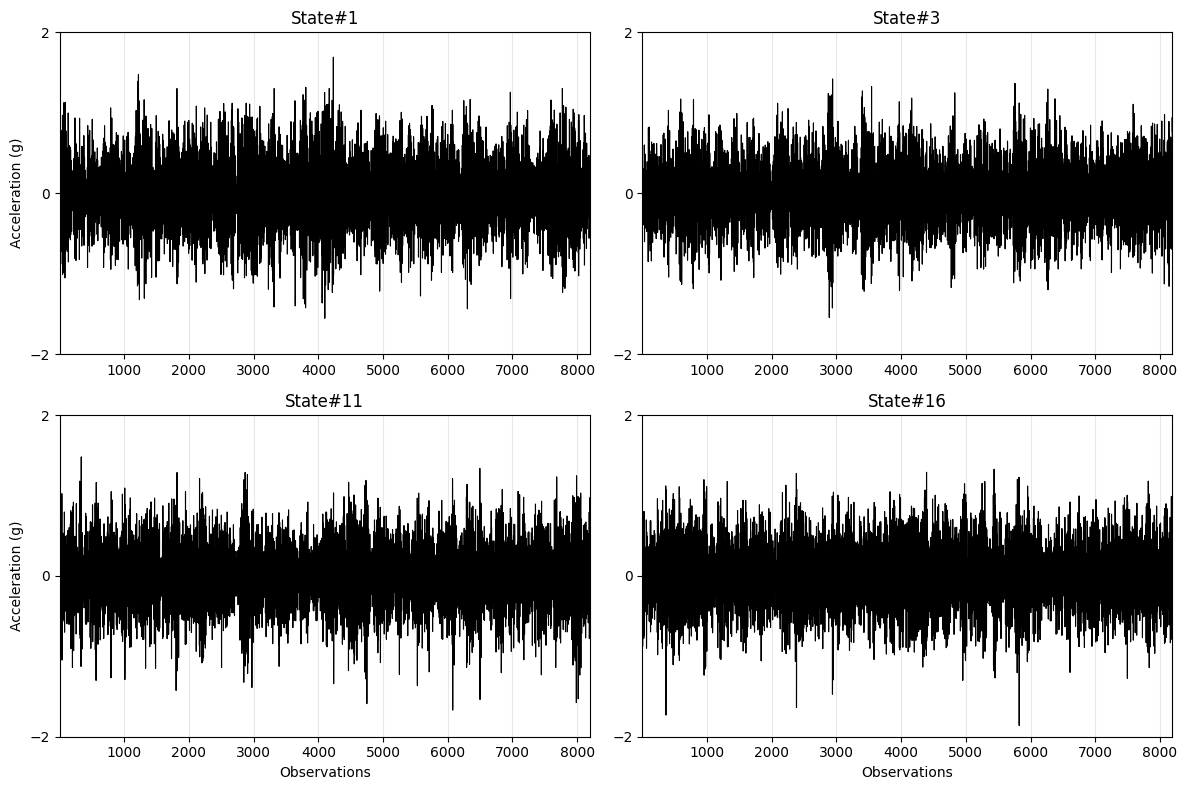

In [3]:
# Plot one acceleration time history from four state conditions
states = [1, 3, 11, 16]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(4):
    # Use state*10 index to match MATLAB indexing pattern
    signal = dataset[:, 4, states[i]*10-1]  # Channel 5, convert to 0-based indexing
    
    axes[i].plot(signal, 'k-', linewidth=0.8)
    axes[i].set_title(f'State#{states[i]}')
    axes[i].set_ylim([-2, 2])
    axes[i].set_xlim([1, 8192])
    axes[i].set_yticks([-2, 0, 2])
    axes[i].grid(True, alpha=0.3)
    
    if i == 2 or i == 3:  # Bottom row
        axes[i].set_xlabel('Observations')
    if i == 0 or i == 2:  # Left column
        axes[i].set_ylabel('Acceleration (g)')

plt.tight_layout()
plt.show()

## Extraction of Damage-Sensitive Features

AR parameters are extracted from acceleration time histories. It is assumed an AR(15) model. The order of the model was picked from the lower-bound of the range given by the optimization methods available in this package. (For more details see example usage)

AR model order:

In [4]:
# AR model order
ar_order = 15

# Estimation of the AR parameters
ar_parameters_fv, rmse_fv, ar_parameters, ar_residuals, ar_prediction = ar_model_shm(dataset[:, 4:5, :], ar_order)

print(f"AR parameters extracted with shape: {ar_parameters.shape}")
print(f"AR parameters FV shape: {ar_parameters_fv.shape}")

/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: divide by zero encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: overflow encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.py:126: RuntimeWarning: invalid value encountered in matmul
  ar_param[:, i] = np.linalg.pinv(A) @ B
/Users/eric/repo/shm/shmtools/features/time_series.

AR parameters extracted with shape: (15, 1, 170)
AR parameters FV shape: (170, 15)


Training data (undamaged feature vectors):

In [5]:
# Training data (undamaged feature vectors)
# MATLAB: for i=1:9; learnData(i*9-8:i*9,:)=arParameters(i*10-9:i*10-1,:); end
learn_data = []
for i in range(9):  # MATLAB states 1-9
    start_idx = i * 10  # State i+1 starts at index i*10
    end_idx = start_idx + 9  # Take 9 samples from each state
    learn_data.extend(ar_parameters_fv[start_idx:end_idx, :])
learn_data = np.array(learn_data)

# Test data (9 undamaged and 8 damaged feature vectors)
# MATLAB: scoreData=arParameters(10:10:170,:);
score_data = ar_parameters_fv[9::10, :]  # Every 10th sample starting from index 9

print(f"Training data shape: {learn_data.shape}")
print(f"Test data shape: {score_data.shape}")

Training data shape: (81, 15)
Test data shape: (17, 15)


Plot test data:

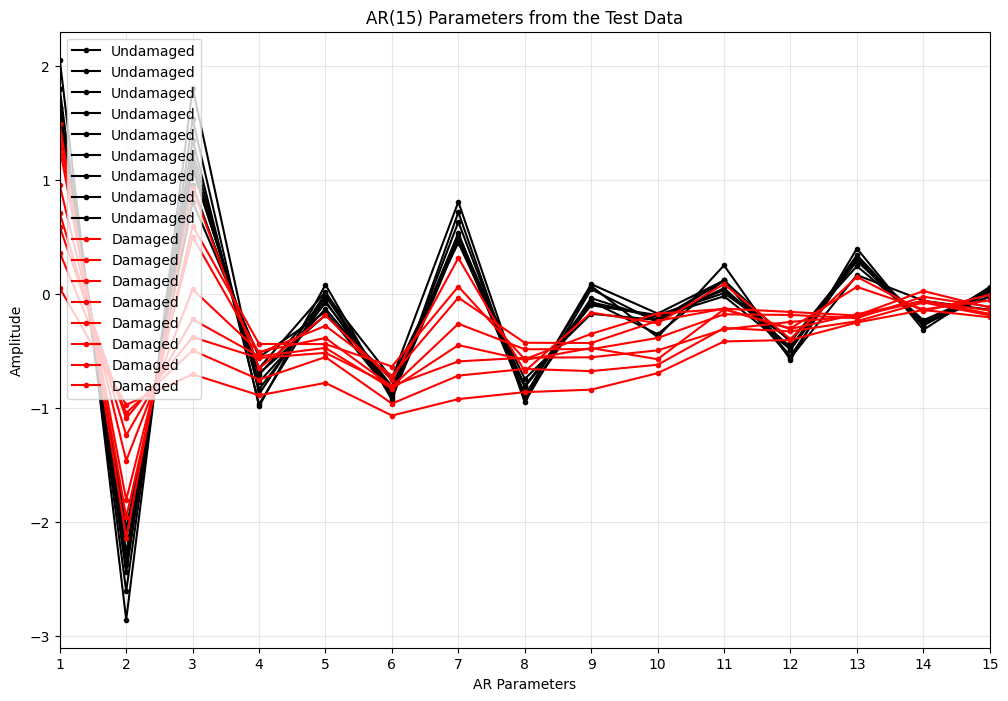

Note: The curves in the figure above correspond to 17 feature vectors
from the undamaged (State#1-9) and damaged conditions (State#10-17).


In [6]:
# Plot test data
plt.figure(figsize=(12, 8))
plt.plot(range(1, ar_order+1), score_data[:9, :].T, '.-k', label='Undamaged')
plt.plot(range(1, ar_order+1), score_data[9:17, :].T, '.-r', label='Damaged')
plt.title(f'AR({ar_order}) Parameters from the Test Data')
plt.xlabel('AR Parameters')
plt.ylabel('Amplitude')
plt.xlim([1, ar_order])
plt.xticks(range(1, ar_order+1))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Note: The curves in the figure above correspond to 17 feature vectors")
print("from the undamaged (State#1-9) and damaged conditions (State#10-17).")

## Statistical Modeling for Feature Classification

The FA-based machine learning algorithm is used to create DIs invariant under feature vectors from the undamaged condition. In this case, two unobserved variables are assumed to quantify the influence of the operational and environmental variations (the changes in mass and stiffness).

Training:

In [7]:
# Training
model = learn_factor_analysis_shm(learn_data, num_factors=2, est_method='thomson')

# Scoring
DI, unique_factors, factor_scores = score_factor_analysis_shm(score_data, model)

print(f"Damage indicators computed for {len(DI)} test instances")

Damage indicators computed for 17 test instances


/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/shm/venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/eric/repo/s

## Plot Damage Indicators

Threshold based on the 95% cut-off over the training data:

In [8]:
# Threshold based on the 95% cut-off over the training data
threshold_DI, _, _ = score_factor_analysis_shm(learn_data, model)
threshold = np.sort(-threshold_DI)
UCL = threshold[int(np.round(len(threshold) * 0.95)) - 1]  # 95% confidence limit

print(f"95% Upper Control Limit: {UCL:.4f}")

95% Upper Control Limit: 3.5311


/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: divide by zero encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T
/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: overflow encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T
/Users/eric/repo/shm/shmtools/classification/outlier_detection.py:907: RuntimeWarning: invalid value encountered in matmul
  unique_factors = Y_standardized - factor_scores @ lambda_matrix.T


Plot DIs:

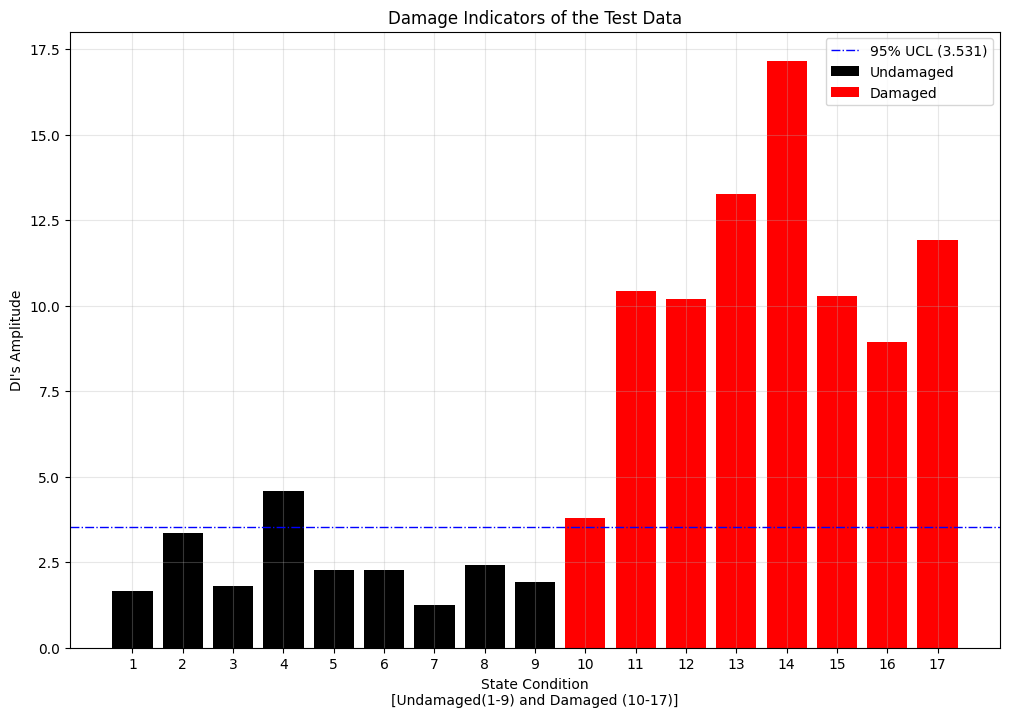


The figure shows that the FA-based machine learning algorithm is able to
discriminate all the damaged state conditions. However, it cannot avoid
one false-positive indication of damaged (State#4). Note however that
this result can be improved by increasing either the number of unobserved
variables or the number of feature vectors in the training data.


In [9]:
# Plot DIs
plt.figure(figsize=(12, 8))
plt.bar(range(1, 10), -DI[:9], color='k', label='Undamaged')
plt.bar(range(10, 18), -DI[9:17], color='r', label='Damaged')
plt.title('Damage Indicators of the Test Data')
plt.xlabel('State Condition\n[Undamaged(1-9) and Damaged (10-17)]')
plt.ylabel("DI's Amplitude")
plt.axhline(y=UCL, color='b', linestyle='-.', linewidth=1, label=f'95% UCL ({UCL:.3f})')
plt.xticks(range(1, 18))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nThe figure shows that the FA-based machine learning algorithm is able to")
print("discriminate all the damaged state conditions. However, it cannot avoid")
print("one false-positive indication of damaged (State#4). Note however that")
print("this result can be improved by increasing either the number of unobserved")
print("variables or the number of feature vectors in the training data.")

## See also:

[Outlier Detection Based on Nonlinear Principal Component Analysis](nlpca_outlier_detection.ipynb)

[Outlier Detection Based on Principal Component Analysis](pca_outlier_detection.ipynb)

[Outlier Detection Based on the Singular Value Decomposition](svd_outlier_detection.ipynb)

[Outlier Detection Based on the Mahalanobis Distance](mahalanobis_outlier_detection.ipynb)